In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [2]:
!pip freeze > requirements.txt

In [3]:
# --- Import Library ---
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# --- Load Dataset ---
df = pd.read_csv('kopken_reviews.csv')
print("Jumlah total data:", len(df))
df.head()

# --- Label Sentimen (2 kelas: positif / negatif) ---
def label_sentiment(score):
    if score <= 3:
        return "negatif"
    else:
        return "positif"

df['sentiment'] = df['score'].apply(label_sentiment)
print(df['sentiment'].value_counts())

Jumlah total data: 10000
sentiment
positif    9459
negatif     541
Name: count, dtype: int64


In [5]:
# --- Preprocessing teks ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)          # hapus link
    text = re.sub(r'[^a-z\s]', '', text)         # hapus angka/tanda baca
    text = re.sub(r'\s+', ' ', text).strip()     # hapus spasi
    return text

df['clean_text'] = df['content'].astype(str).apply(clean_text)
df = df[df['clean_text'] != '']

print("\nContoh data bersih:")
print(df[['clean_text', 'sentiment']].head())


Contoh data bersih:
                                          clean_text sentiment
0                                      senang sekali   positif
1  kode referal di input dimana ini hmm tidak ada...   negatif
2                                               good   positif
3                                            oke lah   positif
4                                              okeee   positif


In [6]:
# --- Split Data (Train 80% - Test 20%) ---
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data latih:", X_train.shape[0])
print("Data uji:", X_test.shape[0])

Data latih: 7858
Data uji: 1965


In [7]:
# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
# --- Inisialisasi & Latih Model ---
svm_model = LinearSVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

LinearSVC(class_weight='balanced', random_state=42)

In [10]:
# --- Evaluasi Model ---
# Prediksi data training dan testing
y_train_pred = svm_model.predict(X_train_tfidf)
y_test_pred = svm_model.predict(X_test_tfidf)

# Hitung akurasi
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Tampilkan hasil
print("=== Evaluasi Model LinearSVC ===")
print(f"Akurasi Data Training : {train_acc * 100:.2f} %")
print(f"Akurasi Data Testing  : {test_acc * 100:.2f} %\n")

print("=== Classification Report (Data Test) ===")
print(classification_report(y_test, y_test_pred))

=== Evaluasi Model LinearSVC ===
Akurasi Data Training : 98.93 %
Akurasi Data Testing  : 95.47 %

=== Classification Report (Data Test) ===
              precision    recall  f1-score   support

     negatif       0.57      0.69      0.63       108
     positif       0.98      0.97      0.98      1857

    accuracy                           0.95      1965
   macro avg       0.78      0.83      0.80      1965
weighted avg       0.96      0.95      0.96      1965



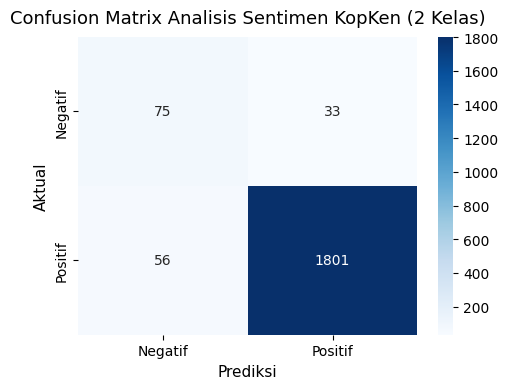

In [11]:
# --- Visualisasi Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negatif', 'Positif'],
    yticklabels=['Negatif', 'Positif']
)
plt.xlabel('Prediksi', fontsize=11)
plt.ylabel('Aktual', fontsize=11)
plt.title('Confusion Matrix Analisis Sentimen KopKen (2 Kelas)', fontsize=13, pad=10)
plt.tight_layout()
plt.show()